In [31]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV3Small
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2

In [32]:
data_dir = 'Dataset'
train_dir = 'split/train'
test_dir = 'split/test'
val_dir = 'split/val'

In [33]:
diseases_name = []
for image_class in os.listdir(train_dir):
    diseases_name.append(image_class)
print(diseases_name)
print(f'Total Disease: {len(diseases_name)}')

['Normal', 'Stroke']
Total Disease: 2


In [34]:
train_data = image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42
)
test_data = image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False,
    seed=42
)
val_data = image_dataset_from_directory(
    val_dir,
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 2000 files belonging to 2 classes.
Found 251 files belonging to 2 classes.
Found 250 files belonging to 2 classes.


In [35]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6,
                                              min_delta=0.0001)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2,
                                                 patience=4, min_lr=1e-7)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

In [36]:
n_class = len(diseases_name)

model = Sequential()

pretrained_model = MobileNetV3Small(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='max',
    weights='imagenet'
)

pretrained_model.trainable = False


pretrained_model = Model(
    inputs=pretrained_model.inputs,
    outputs=pretrained_model.layers[-2].output
)
model.add(pretrained_model)

model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(n_class, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 7, 7, 576)         939120    
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 576)        2304      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten_1 (Flatten)         (None, 576)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                18464     
                                                                 
 dense_3 (Dense)             (None, 64)               

In [37]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [38]:
hist = model.fit(train_data, epochs=50, validation_data=val_data,
                 callbacks=[
                    early_stop,
                 ])

Epoch 1/50
63/63 [==============================] - 14s 113ms/step - loss: 0.6210 - accuracy: 0.6420 - val_loss: 0.5860 - val_accuracy: 0.6760
Epoch 2/50
63/63 [==============================] - 4s 53ms/step - loss: 0.4850 - accuracy: 0.7660 - val_loss: 0.4665 - val_accuracy: 0.7760
Epoch 3/50
63/63 [==============================] - 3s 51ms/step - loss: 0.3527 - accuracy: 0.8550 - val_loss: 0.4380 - val_accuracy: 0.7840
Epoch 4/50
63/63 [==============================] - 3s 47ms/step - loss: 0.2664 - accuracy: 0.8820 - val_loss: 0.4249 - val_accuracy: 0.7960
Epoch 5/50
63/63 [==============================] - 4s 54ms/step - loss: 0.2112 - accuracy: 0.9095 - val_loss: 0.2994 - val_accuracy: 0.8840
Epoch 6/50
63/63 [==============================] - 4s 55ms/step - loss: 0.1527 - accuracy: 0.9400 - val_loss: 0.4335 - val_accuracy: 0.8480
Epoch 7/50
63/63 [==============================] - 4s 54ms/step - loss: 0.1364 - accuracy: 0.9505 - val_loss: 0.3355 - val_accuracy: 0.8640
Epoch 8/50


In [39]:
model.save('saved_models/MobileNet.h5')

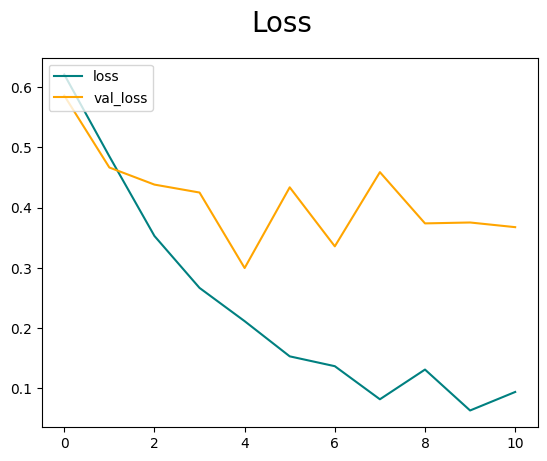

In [40]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

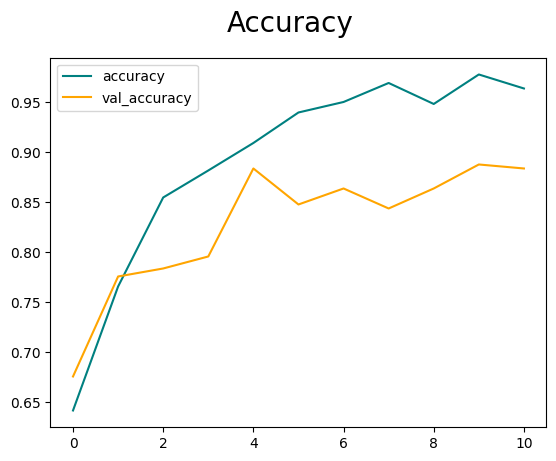

In [41]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [42]:
test_loss, test_acc = model.evaluate(test_data)
print(f'Test Loss: {test_loss} Test Accuracy: {test_acc}')

8/8 [==============================] - 1s 119ms/step - loss: 0.4860 - accuracy: 0.8486
Test Loss: 0.4859902560710907 Test Accuracy: 0.8486055731773376


In [43]:
y_pred = model.predict(test_data)

8/8 [==============================] - 2s 48ms/step


1/1 [==============================] - 2s 2s/step


<AxesSubplot: >

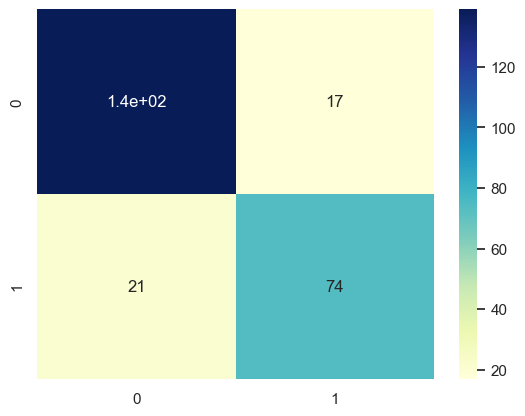

In [44]:
sns.set()
y_pred = []
for x, y in test_data:
    y_pred.extend(np.argmax(model.predict(x), axis=1).tolist())

y_true = []
for x, y in test_data:
    y_true.extend(np.argmax(y, axis=1).tolist())

conf_mat = confusion_matrix(y_true, y_pred)

sns.heatmap(conf_mat, annot=True, cmap="YlGnBu")

1/1 [==============================] - 0s 79ms/step


<AxesSubplot: >

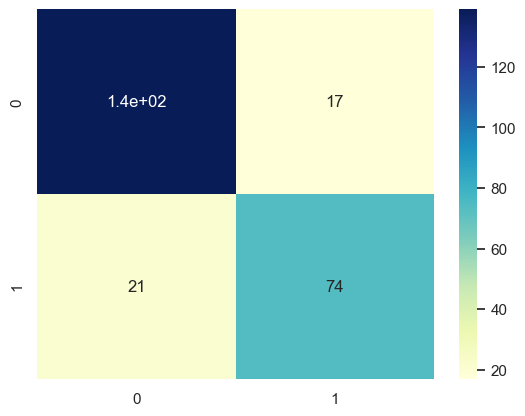

In [45]:
sns.set()
y_pred = []
for x, y in test_data:
    y_pred.extend(np.argmax(model.predict(x), axis=1).tolist())


y_true = []
for x, y in test_data:
    y_true.extend(np.argmax(y, axis=1).tolist())

conf_mat = confusion_matrix(y_true, y_pred)

sns.heatmap(conf_mat, annot=True, cmap="YlGnBu")

In [46]:
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)

print(f'precision: {np.average(precision)}')
print(f'Recall: {np.average(recall)}')

precision: 0.8409684065934067
Recall: 0.8349865047233469
